In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

import IPython.display as ipd

import numpy as np
import pandas as pd
import torch

from hparams import create_hparams
from model import SpeakerEncoder
from loss import SpeakerEncoderLoss
from audio import init_stft, mel_spectrogram

import os
import warnings
warnings.filterwarnings("ignore")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/Users/olehmatsuk/opt/anaconda3/envs/taco/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
F = 70

def get_embeddings(model, data, data_dir):
    embeddings = []
    for _, row in data.iterrows():
        mel = mel_spectrogram(os.path.join(data_dir, row['audio']), stft).transpose(0, 1).unsqueeze(0) # 1xSxM
        fragments = mel.unfold(1, F, F // 2).transpose(2, 3)[0]
        embedding = model.inference(fragments, [fragments.size(0)]).squeeze(0)
        embeddings.append(embedding)
    return torch.stack(embeddings).detach()

In [3]:
def load_model(checkpoint_path):
    model = SpeakerEncoder(hparams)
    if checkpoint_path is not None: 
        model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])
    return model

In [4]:
import IPython

def play_audio(audio, data_dir):
    return IPython.display.Audio(os.path.join(data_dir, audio))

In [5]:
def get_speaker_sample(data, speaker):
    return data.loc[data['speaker'] == speaker].sample(1).iloc[0]

In [6]:
from sklearn.decomposition import PCA

def pca_plot(embeddings, labels, genders=None):
    sns.set(rc={'figure.figsize':(12, 12)})
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings.numpy())

    for label in np.sort(np.unique(labels)):
        label_index = labels == label
        marker = None if genders is None else ('x' if genders[label] else '.')
        plt.scatter(embeddings_2d[label_index, 0], embeddings_2d[label_index, 1], label=label, marker=marker)
    if genders is not None:
        plt.legend()

In [7]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import PCA

def embedding_stats(embeddings, N, M):
    loss = sum([SpeakerEncoderLoss(N, M, w, -5.0)(embeddings, None).item()
                for w in [5.0, 10.0, 20.0, 40.0]]) / 4
    S = linear_kernel(embeddings)
    S_min, S_max  = np.min(S), np.max(S)

    C = [] # N * MxM
    D = [] # N * M(N-1)xM
    for j in range(N):
        cl = S[j*M:(j+1)*M, j*M:(j+1)*M]
        C.append(S[j*M:(j+1)*M, j*M:(j+1)*M])
        D.append(np.hstack([S[j*M:(j+1)*M, :j*M], S[j*M:(j+1)*M, (j+1)*M:]]))

    C_avg, C_var = np.mean(C), np.var(C)
    D_avg, D_var = np.mean(D), np.var(D)
    
    pca = PCA()
    pca.fit(embeddings)
    ex_var = pca.explained_variance_ratio_[:3].sum()
    
    print(f'Loss {loss:.2f}')
    print(f'Similarity  max {S_max:.2f} min {S_min:.2f}')
    print(f'Clusterness (+) avg {C_avg:.2f} var {C_var:.2f}')
    print(f'Distance    (-) avg {D_avg:.2f} var {D_var:.2f}')
    print(f'Variance {ex_var:.2f}')
    return [loss, S_max, S_min, C_avg, C_var, D_avg, D_var, ex_var]

In [8]:
hparams = create_hparams()
stft = init_stft(hparams)

### Load data

In [9]:
test_common_voice = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/common_voice_test.csv')
test_common_voice.head()

,text,audio,mel,mel_len,speaker
0,Ainsaks võimaluseks liigutada on otse ees olev...,common_voice_et_20836428.mp3,common_voice_et_20836428.npy,581,af3761962fc232e39bd00b879c0cb6efe2aea2f2be4967...
1,Seda suve jääb meenutama kullast teemantidega ...,common_voice_et_20808754.mp3,common_voice_et_20808754.npy,377,53766c5456ef60e9656bf8d8676576cb3644e8aa7eb917...
2,Selleks tuleks ära lugeda istmeread enda ja uk...,common_voice_et_18317620.mp3,common_voice_et_18317620.npy,736,65339a2db81918d9511619601cbbee3d9e6916275c099e...
3,Võistkonna pealiku Michel Nandani sõnul tuleva...,common_voice_et_20803724.mp3,common_voice_et_20803724.npy,612,ca68c58c7ed4883fd69286e66eaadd1d2298b7918ce03f...
4,Ilmselt oskavad nad seda hinnata.,common_voice_et_18313543.mp3,common_voice_et_18313543.npy,288,974410114cfdedc71740c28fc7209922c02b598513c185...


In [10]:
test_konekorpus = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/konekorpus_test.csv')
test_konekorpus.head()

,text,audio,mel,mel_len,speaker
0,Kuid toonane ja praegune Prantsusmaa koondis o...,Katarina/0001_art_864_lause_3.wav,Katarina_0001_art_864_lause_3.npy,247,Katarina
1,"""Põrsas kotis"" festivali raames toimub kuus ko...",Robert/0001_art_860_lause_3.wav,Robert_0001_art_860_lause_3.npy,721,Robert
2,Samas lähedal Kanada piiri ääres möllab metsap...,Kristo/0001_art_367_lause_2.wav,Kristo_0001_art_367_lause_2.npy,907,Kristo
3,Kaks neist majadest rajatakse Jaamamõisa tänav...,Katarina/0001_art_395_lause_11.wav,Katarina_0001_art_395_lause_11.npy,647,Katarina
4,Jaapanile alla jäänud Kolumbia oli teenitult g...,Katarina/0001_art_796_lause_1.wav,Katarina_0001_art_796_lause_1.npy,661,Katarina


In [11]:
test_vctk = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/vctk_test.csv')
test_vctk.head()

,text,audio,mel,mel_len,speaker
0,The body follows the mind.\n,wav48/p240/p240_233.wav,p240_233.npy,258,p240
1,We want to get there.\n,wav48/p244/p244_160.wav,p244_160.npy,240,p244
2,They have known the hard times.,wav48/p292/p292_160.wav,p292_160.npy,236,p292
3,I was just trying to win the golf tournament.\n,wav48/p269/p269_070.wav,p269_070.npy,273,p269
4,My main concern is that public health is not p...,wav48/p279/p279_190.wav,p279_190.npy,298,p279


In [12]:
test_common_voice.shape, test_konekorpus.shape, test_vctk.shape

((2118, 5), (9407, 5), (8817, 5))

In [13]:
common_voice_dir = '/Users/olehmatsuk/Thesis/data/common_voice/et/clips'
konekorpus_dir = '/Users/olehmatsuk/Thesis/data/konekorpus'
vctk_dir = '/Users/olehmatsuk/Thesis/data/vctk'

In [14]:
konekorpus_speakers_genders = {"Meelis_Kompus": 1, 
                               "Tarmo_Maiberg": 1, 
                               "Birgit_Itse": 0, 
                               "Vallo_Kelmsaar": 1, 
                               "Indrek_Kiisler": 1, 
                               "Tõnu_Karjatse": 1, 
                               "Kai_Vare": 0, 
                               "Katarina": 0,
                               "Kristo": 1, 
                               "Robert": 1, 
                               "Stella": 0}

In [15]:
vctk_speaker_info = pd.read_csv(os.path.join(vctk_dir, 'speaker-info.txt'), delimiter='\s*', header=None, skiprows=1)
vctk_speakers_genders = {f'p{row[0]}': 1 if row[2] == 'M' else 0
                         for _, row in vctk_speaker_info.iterrows()}
vctk_speakers_genders['p280'] = 0

### Prepare test data

In [16]:
test_konekorpus_sample = []
for speaker in test_konekorpus['speaker'].unique():
    speaker_sample = test_konekorpus.loc[(test_konekorpus['speaker'] == speaker) & \
                                         (test_konekorpus['mel_len'] >= F)].sample(10)
    test_konekorpus_sample.append(speaker_sample)
test_konekorpus_sample = pd.concat(test_konekorpus_sample)
test_konekorpus_sample.head()

,text,audio,mel,mel_len,speaker
6017,Seda kõike majanduskasvu nimel.,Katarina/0001_art_660_lause_13.wav,Katarina_0001_art_660_lause_13.npy,125,Katarina
8876,"Taro ütles Delfile, et on prokuratuuri kokkuvõ...",Katarina/0001_art_603_lause_1.wav,Katarina_0001_art_603_lause_1.npy,1599,Katarina
8672,"Silver Kuusik: ""See tunne pole uus.",Katarina/0001_art_1113_lause_5.wav,Katarina_0001_art_1113_lause_5.npy,179,Katarina
4757,Türi muusikakooli lõpetamise järel Tallinnas G...,Katarina/0001_art_684_lause_2.wav,Katarina_0001_art_684_lause_2.npy,807,Katarina
284,Üritus tuli Uudole üllatusena.,Katarina/0001_art_207_lause_6.wav,Katarina_0001_art_207_lause_6.npy,137,Katarina


In [17]:
test_common_voice_sample = []
test_common_voice_speakers = test_common_voice.groupby('speaker'). \
    filter(lambda s: sum(s['mel_len'] >= F) > 10)['speaker'].unique()
for speaker in np.random.choice(test_common_voice_speakers, size=30, replace=False):
    test_common_voice_sample.append(test_common_voice.loc[(test_common_voice['speaker'] == speaker) & \
                                                          (test_common_voice['mel_len'] >= F)].sample(10))
test_common_voice_sample = pd.concat(test_common_voice_sample)
test_common_voice_sample.head()

,text,audio,mel,mel_len,speaker
75,"Selle asemel, et iga nädal prügikotti vahetada...",common_voice_et_18321195.mp3,common_voice_et_18321195.npy,664,fa7f67d93b2f3a6e685275897b5b67653df98a2880d1a8...
1058,Seda ei saa aga muidu kui administratiivsete m...,common_voice_et_18169340.mp3,common_voice_et_18169340.npy,561,fa7f67d93b2f3a6e685275897b5b67653df98a2880d1a8...
1379,Uus olukord loob uusi võimalusi koostööks.,common_voice_et_18149429.mp3,common_voice_et_18149429.npy,344,fa7f67d93b2f3a6e685275897b5b67653df98a2880d1a8...
1042,"Paraku on nii, et tilk tõrva meepotis võib ära...",common_voice_et_18172641.mp3,common_voice_et_18172641.npy,602,fa7f67d93b2f3a6e685275897b5b67653df98a2880d1a8...
404,See on viimase seitsme aasta suurim kasuminumber.,common_voice_et_18136206.mp3,common_voice_et_18136206.npy,433,fa7f67d93b2f3a6e685275897b5b67653df98a2880d1a8...


In [18]:
test_vctk_sample = []
for speaker in np.random.choice(test_vctk['speaker'].unique(), size=15, replace=False):
    test_vctk_sample.append(test_vctk.loc[(test_vctk['speaker'] == speaker) & \
                                          (test_vctk['mel_len'] >= F)].sample(20))
test_vctk_sample = pd.concat(test_vctk_sample)
test_vctk_sample.head()

,text,audio,mel,mel_len,speaker
8058,The big issue for us is the review.,wav48/p307/p307_178.wav,p307_178.npy,409,p307
2049,It was a moment of madness.,wav48/p307/p307_266.wav,p307_266.npy,313,p307
2816,"They were the best team, but unlucky in the end.",wav48/p307/p307_357.wav,p307_357.npy,383,p307
1415,"JOHN Anderson, the former Scottish national co...",wav48/p307/p307_253.wav,p307_253.npy,692,p307
8402,"Of course, on Tuesday, United were beaten desp...",wav48/p307/p307_098.wav,p307_098.npy,519,p307


In [19]:
test_konekorpus_sample.shape, test_common_voice_sample.shape, test_vctk_sample.shape

((110, 5), (300, 5), (300, 5))

In [20]:
def run_test_konekorpus(model):
    embeddings_konekorpus = get_embeddings(model, test_konekorpus_sample, konekorpus_dir)
    stats = embedding_stats(embeddings_konekorpus, 11, 10)
    pca_plot(embeddings_konekorpus, test_konekorpus_sample['speaker'], konekorpus_speakers_genders)
    plt.show()
    return stats

In [21]:
def run_test_vctk(model):
    embeddings_vctk = get_embeddings(model, test_vctk_sample, vctk_dir)
    stats = embedding_stats(embeddings_vctk, 15, 20)
    pca_plot(embeddings_vctk, test_vctk_sample['speaker'], vctk_speakers_genders)
    plt.show()
    return stats

In [22]:
def run_test_common_voice(model):
    embeddings_common_voice = get_embeddings(model, test_common_voice_sample, common_voice_dir)
    stats = embedding_stats(embeddings_common_voice, 20, 15)
    pca_plot(embeddings_common_voice, test_common_voice_sample['speaker'])
    plt.show()
    return stats

### Load models

In [23]:
sample = get_speaker_sample(test_vctk, 'p280')
play_audio(sample['audio'], vctk_dir)

In [24]:
sample = get_speaker_sample(test_konekorpus, 'Indrek_Kiisler')
play_audio(sample['audio'], konekorpus_dir)

In [25]:
models = {
    'konekorpus 80': '/Users/olehmatsuk/Thesis/runs/speaker_k_Jul04_23_08_52/checkpoint_80000',
    'common_voice 80':  '/Users/olehmatsuk/Thesis/runs/speaker_c_Jul04_23_05_50/checkpoint_80000',
    'common_voice 140': '/Users/olehmatsuk/Thesis/runs/speaker_c_Jul04_23_05_50/checkpoint_140000',
    'common_voice 196': '/Users/olehmatsuk/Thesis/runs/speaker_c_Jul04_23_05_50/checkpoint_196000',
    'common_voice + konekorpus 80':  '/Users/olehmatsuk/Thesis/runs/speaker_ck_Jul04_23_23_32/checkpoint_80000',
    'common_voice + konekorpus 140': '/Users/olehmatsuk/Thesis/runs/speaker_ck_Jul04_23_23_32/checkpoint_140000',
    'common_voice + konekorpus 180': '/Users/olehmatsuk/Thesis/runs/speaker_ck_Jul04_23_23_32/checkpoint_180000',
    'vctk 80':  '/Users/olehmatsuk/Thesis/runs/speaker_v_Jul04_23_05_50/checkpoint_80000',
    'vctk 140': '/Users/olehmatsuk/Thesis/runs/speaker_v_Jul04_23_05_50/checkpoint_140000',
    'vctk 216': '/Users/olehmatsuk/Thesis/runs/speaker_v_Jul04_23_05_50/checkpoint_216000',
}

#### Konekorpus Test Data

konekorpus 80
Loss 2.48
Similarity  max 1.00 min -0.97
Clusterness (+) avg 1.00 var 0.00
Distance    (-) avg -0.09 var 0.11
Variance 0.66


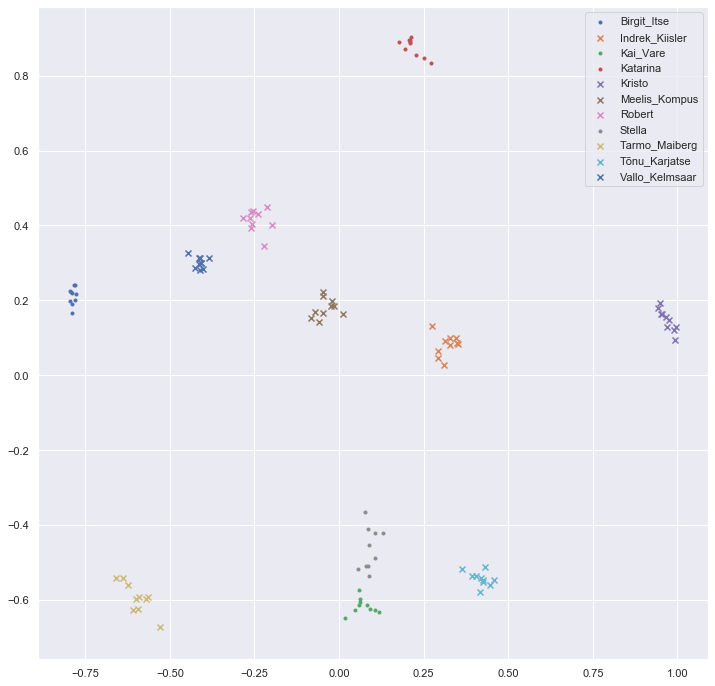

common_voice 80
Loss 53.40
Similarity  max 1.00 min -0.42
Clusterness (+) avg 0.87 var 0.01
Distance    (-) avg 0.34 var 0.09
Variance 0.69


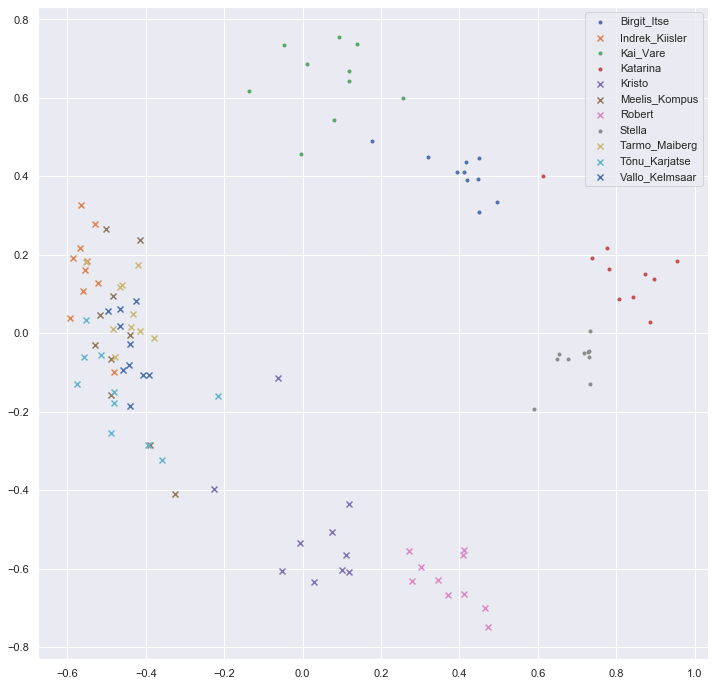

common_voice 140
Loss 31.43
Similarity  max 1.00 min -0.50
Clusterness (+) avg 0.77 var 0.03
Distance    (-) avg 0.19 var 0.07
Variance 0.56


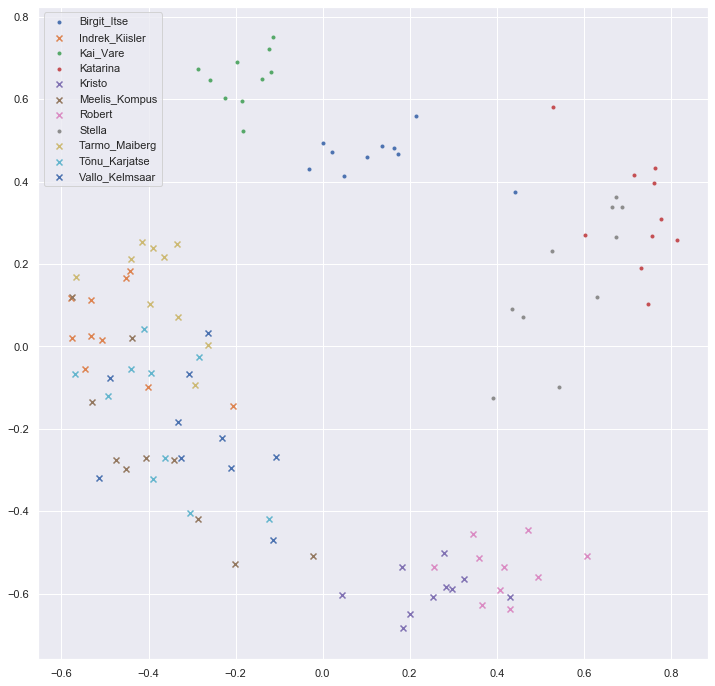

common_voice 196
Loss 34.02
Similarity  max 1.00 min -0.55
Clusterness (+) avg 0.79 var 0.02
Distance    (-) avg 0.24 var 0.06
Variance 0.55


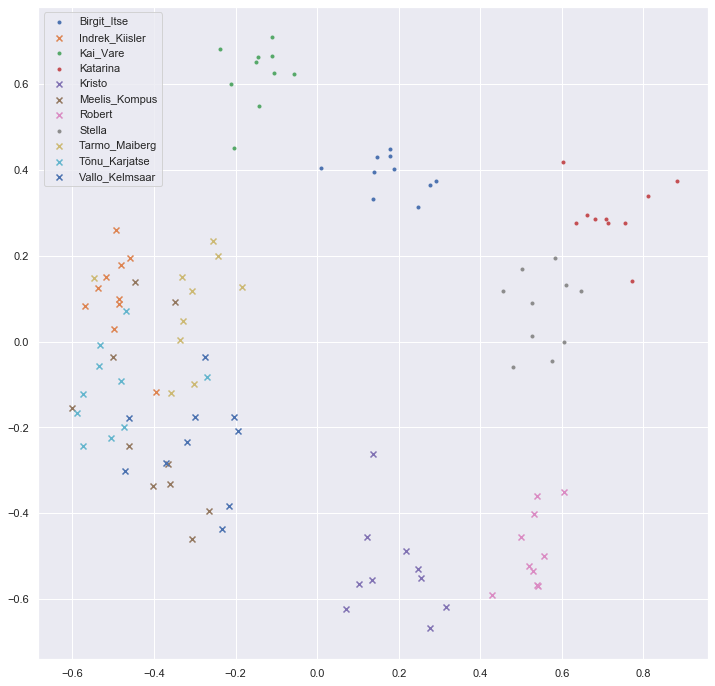

common_voice + konekorpus 80
Loss 9.40
Similarity  max 1.00 min -0.44
Clusterness (+) avg 0.97 var 0.00
Distance    (-) avg 0.23 var 0.05
Variance 0.64


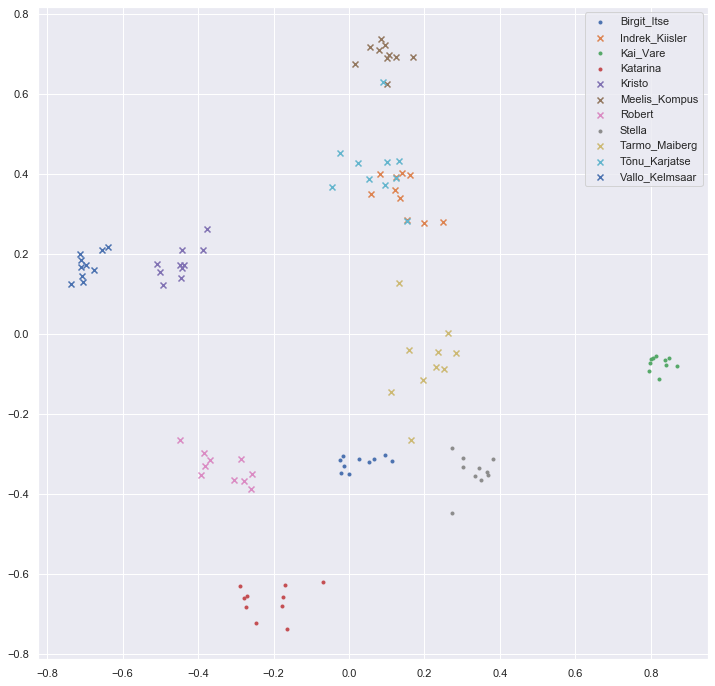

common_voice + konekorpus 140
Loss 5.97
Similarity  max 1.00 min -0.32
Clusterness (+) avg 0.97 var 0.00
Distance    (-) avg 0.16 var 0.03
Variance 0.52


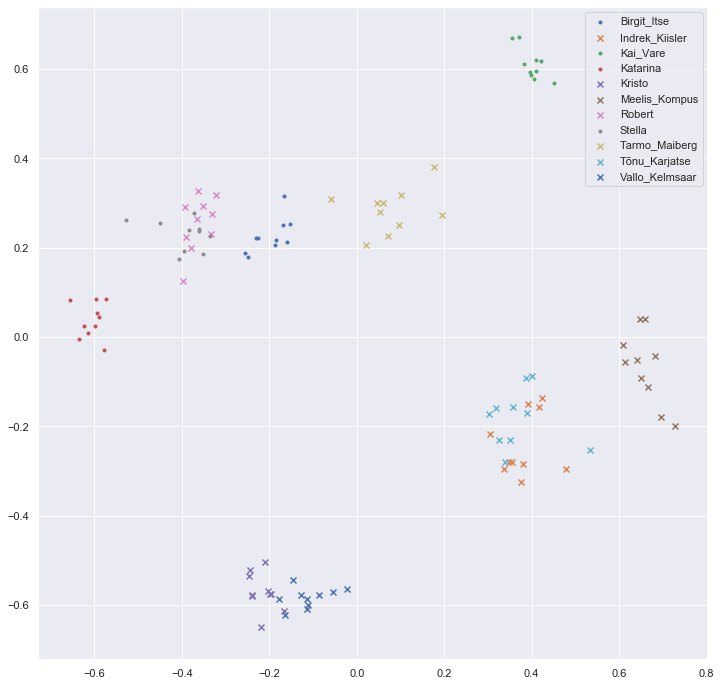

common_voice + konekorpus 180
Loss 5.86
Similarity  max 1.00 min -0.25
Clusterness (+) avg 0.96 var 0.00
Distance    (-) avg 0.18 var 0.02
Variance 0.48


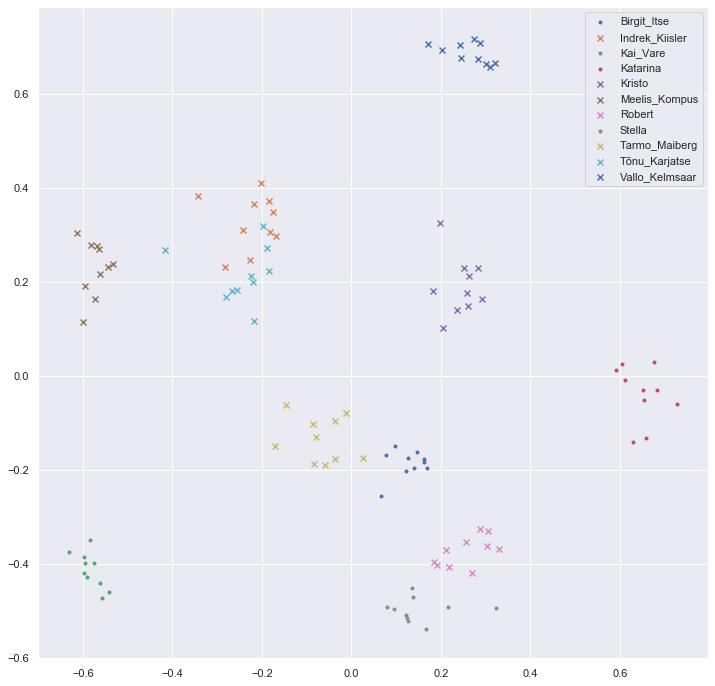

vctk 80
Loss 74.40
Similarity  max 1.00 min -0.39
Clusterness (+) avg 0.84 var 0.03
Distance    (-) avg 0.30 var 0.11
Variance 0.68


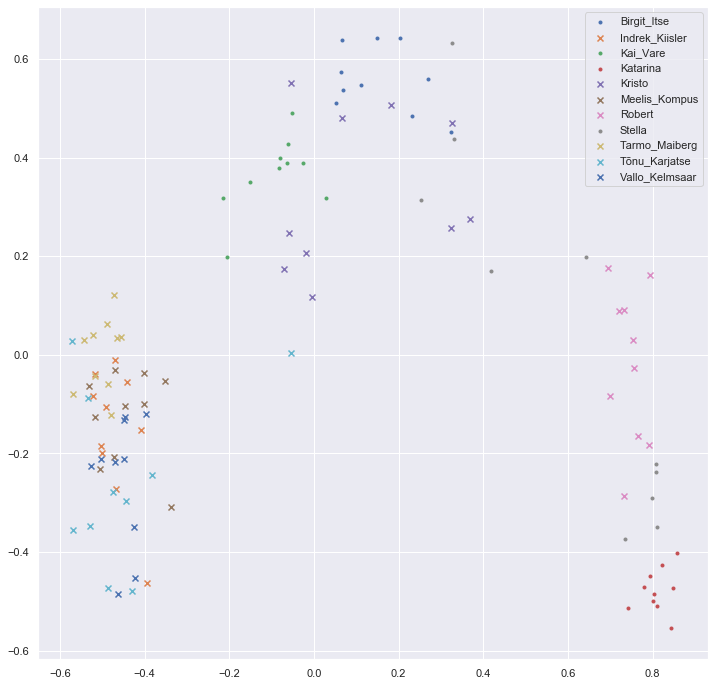

vctk 140
Loss 49.15
Similarity  max 1.00 min -0.43
Clusterness (+) avg 0.85 var 0.02
Distance    (-) avg 0.23 var 0.10
Variance 0.66


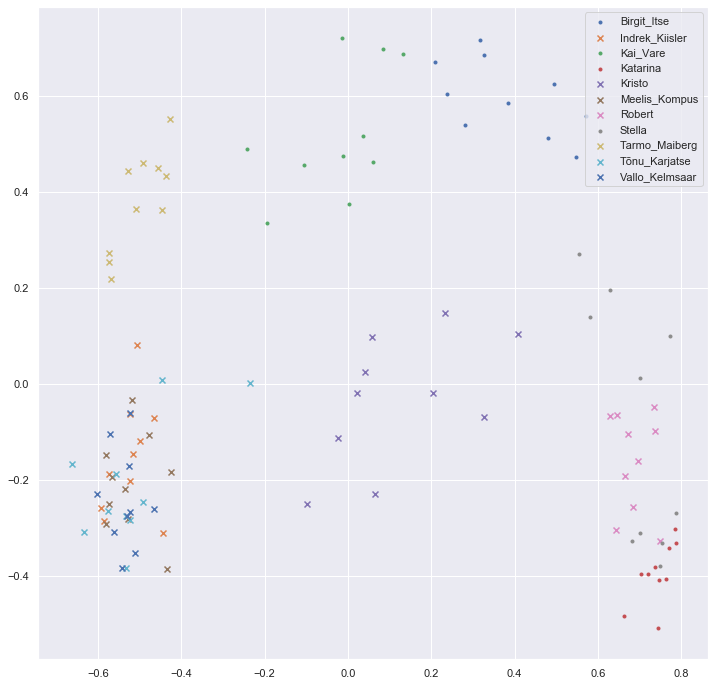

vctk 216
Loss 39.77
Similarity  max 1.00 min -0.47
Clusterness (+) avg 0.79 var 0.02
Distance    (-) avg 0.21 var 0.08
Variance 0.60


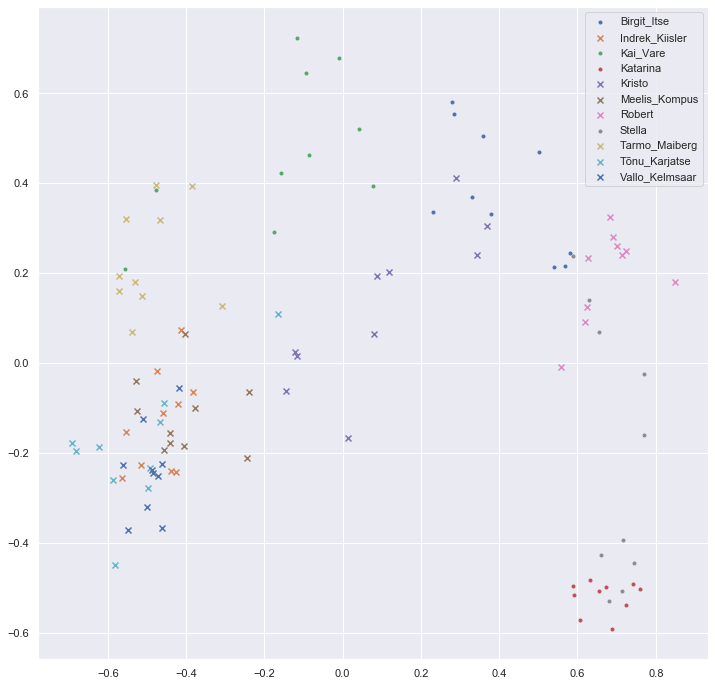

In [26]:
konekorpus_stats = {}
for name, checkpoint in models.items():
    model = load_model(checkpoint)
    print(name)
    konekorpus_stats[name] = run_test_konekorpus(model)

#### VCTK Test Data

konekorpus 80
Loss 398.70
Similarity  max 1.00 min -0.98
Clusterness (+) avg 0.88 var 0.02
Distance    (-) avg 0.33 var 0.20
Variance 0.89


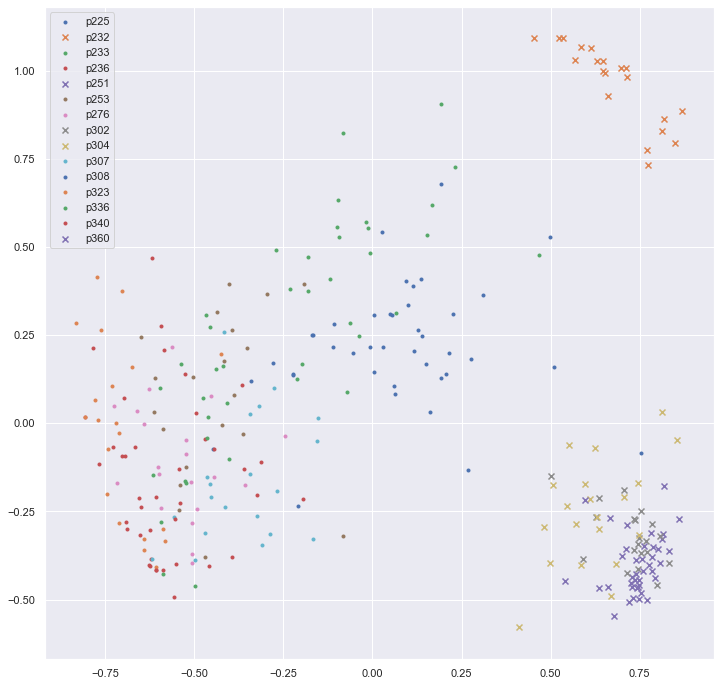

common_voice 80
Loss 395.06
Similarity  max 1.00 min 0.01
Clusterness (+) avg 0.94 var 0.00
Distance    (-) avg 0.74 var 0.03
Variance 0.69


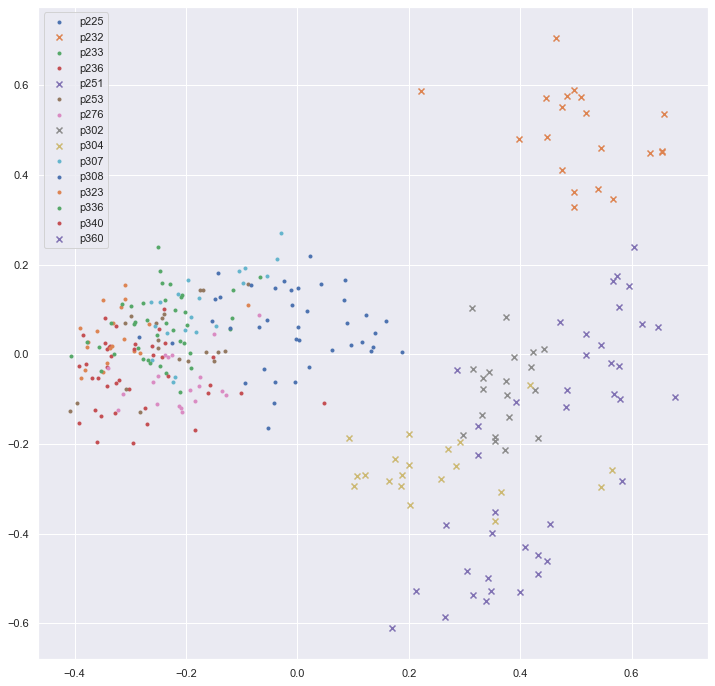

common_voice 140
Loss 345.24
Similarity  max 1.00 min 0.02
Clusterness (+) avg 0.92 var 0.00
Distance    (-) avg 0.70 var 0.03
Variance 0.61


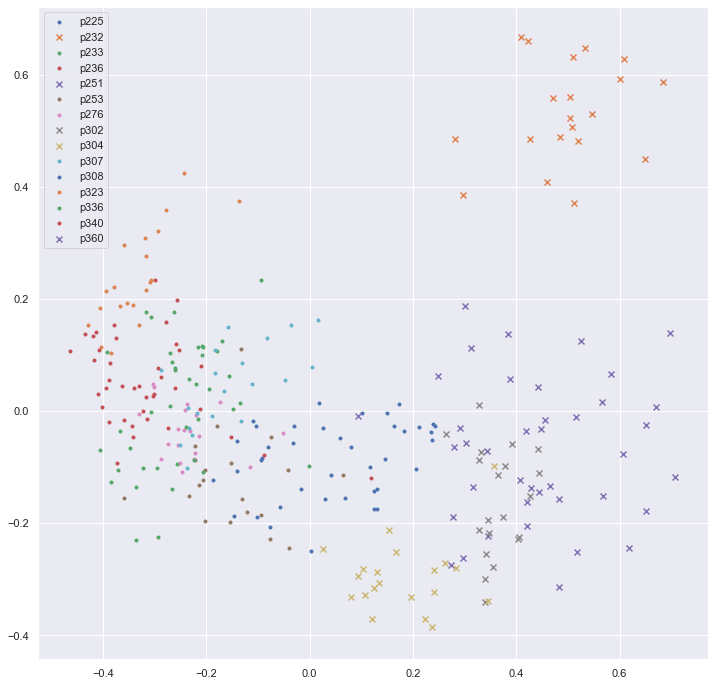

common_voice 196
Loss 313.62
Similarity  max 1.00 min -0.24
Clusterness (+) avg 0.89 var 0.01
Distance    (-) avg 0.62 var 0.05
Variance 0.59


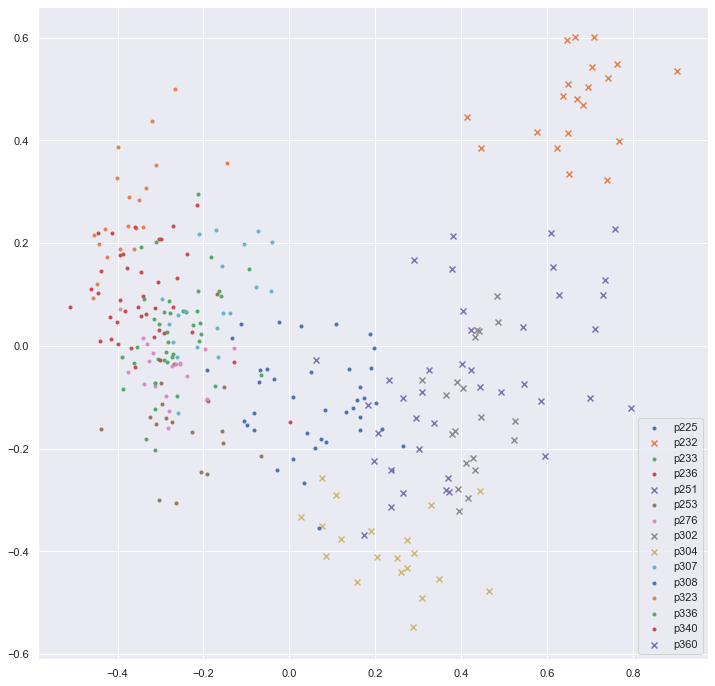

common_voice + konekorpus 80
Loss 369.13
Similarity  max 1.00 min 0.03
Clusterness (+) avg 0.94 var 0.00
Distance    (-) avg 0.73 var 0.03
Variance 0.70


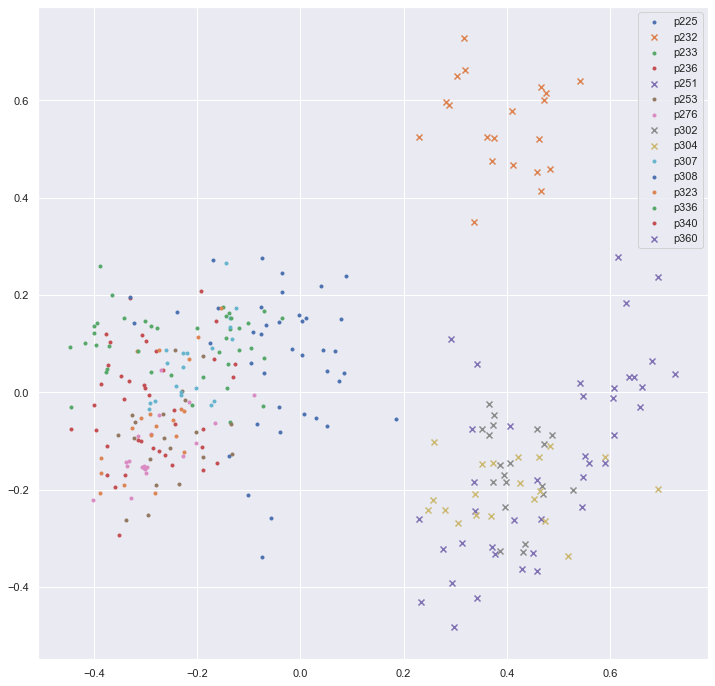

common_voice + konekorpus 140
Loss 371.12
Similarity  max 1.00 min 0.14
Clusterness (+) avg 0.93 var 0.00
Distance    (-) avg 0.72 var 0.03
Variance 0.65


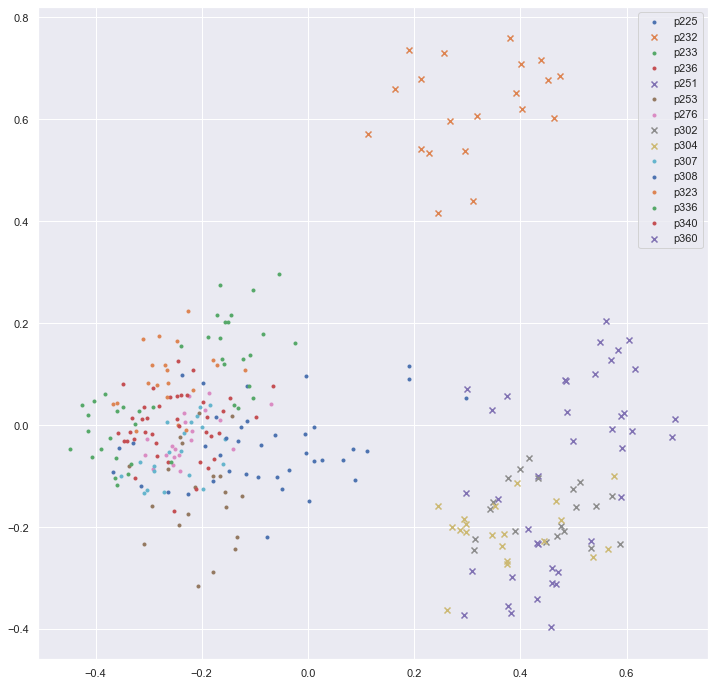

common_voice + konekorpus 180
Loss 312.38
Similarity  max 1.00 min 0.03
Clusterness (+) avg 0.92 var 0.00
Distance    (-) avg 0.67 var 0.03
Variance 0.59


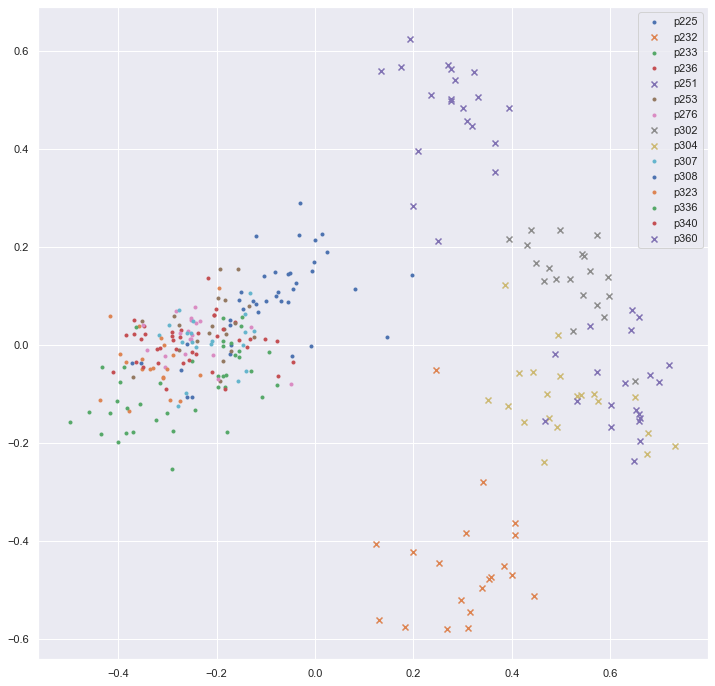

vctk 80
Loss 33.74
Similarity  max 1.00 min -0.72
Clusterness (+) avg 0.92 var 0.00
Distance    (-) avg 0.07 var 0.08
Variance 0.56


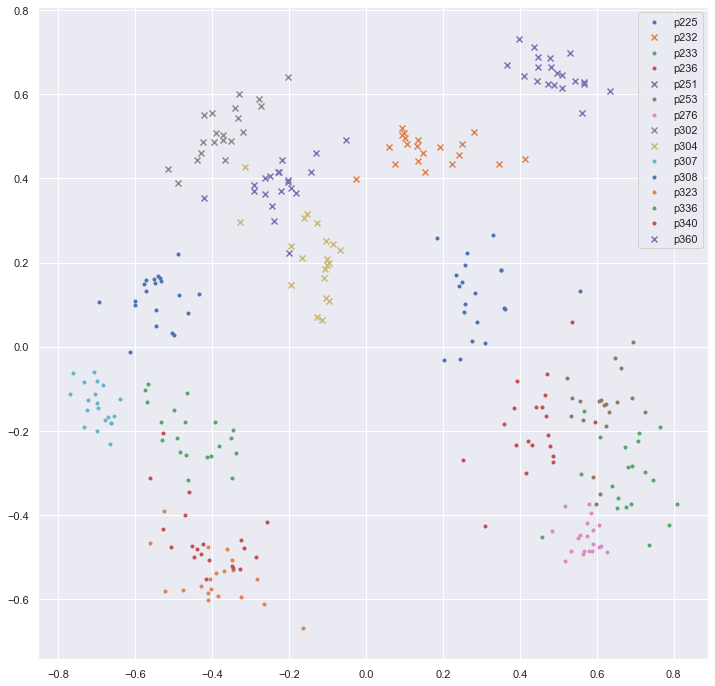

vctk 140
Loss 22.02
Similarity  max 1.00 min -0.72
Clusterness (+) avg 0.92 var 0.00
Distance    (-) avg 0.04 var 0.06
Variance 0.49


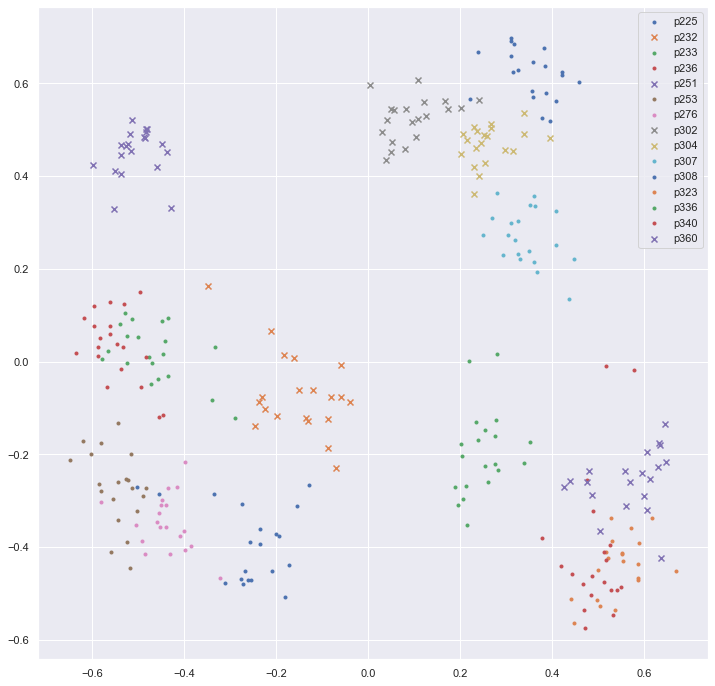

vctk 216
Loss 19.47
Similarity  max 1.00 min -0.64
Clusterness (+) avg 0.93 var 0.00
Distance    (-) avg 0.05 var 0.05
Variance 0.44


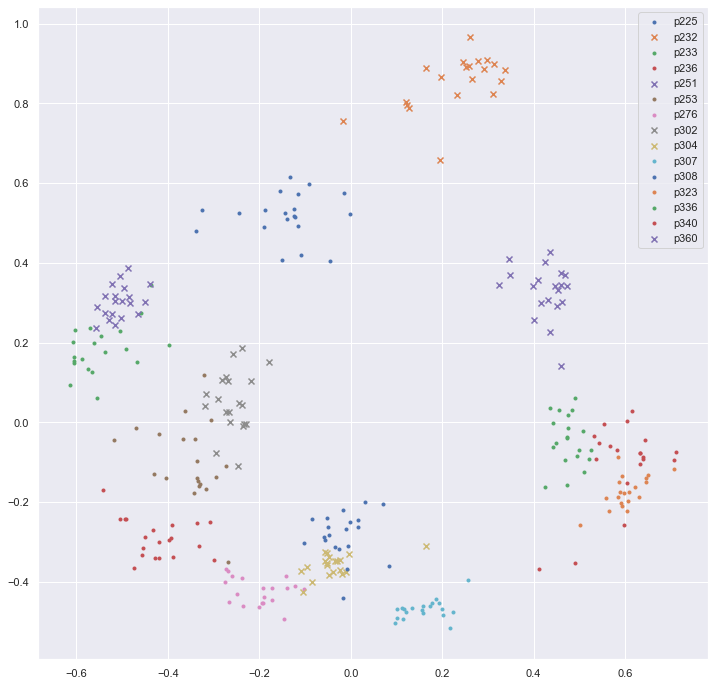

In [27]:
vctk_stats = {}
for name, checkpoint in models.items():
    model = load_model(checkpoint)
    print(name)
    vctk_stats[name] = run_test_vctk(model)

#### Common Voice Test data

konekorpus 80
Loss 1499.58
Similarity  max 1.00 min -0.99
Clusterness (+) avg 0.52 var 0.26
Distance    (-) avg 0.24 var 0.23
Variance 0.83


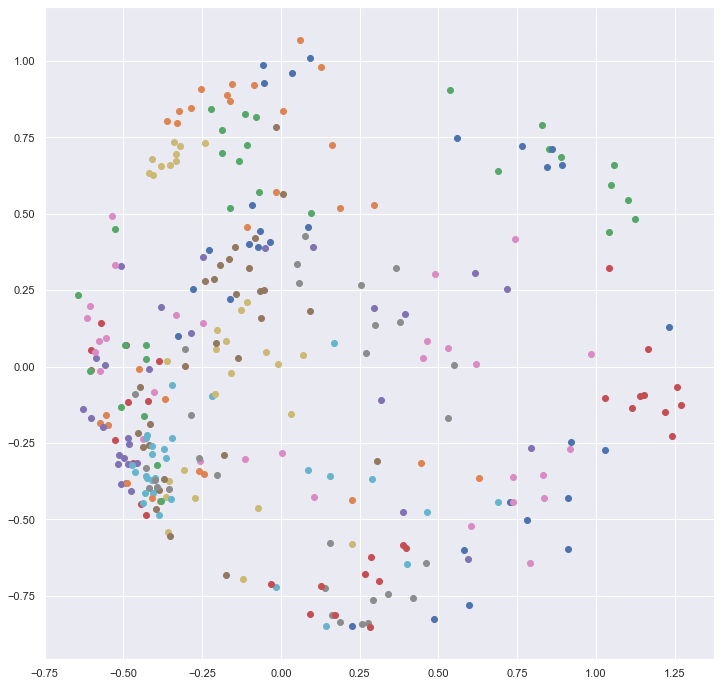

common_voice 80
Loss 494.23
Similarity  max 1.00 min -0.78
Clusterness (+) avg 0.49 var 0.25
Distance    (-) avg 0.03 var 0.08
Variance 0.41


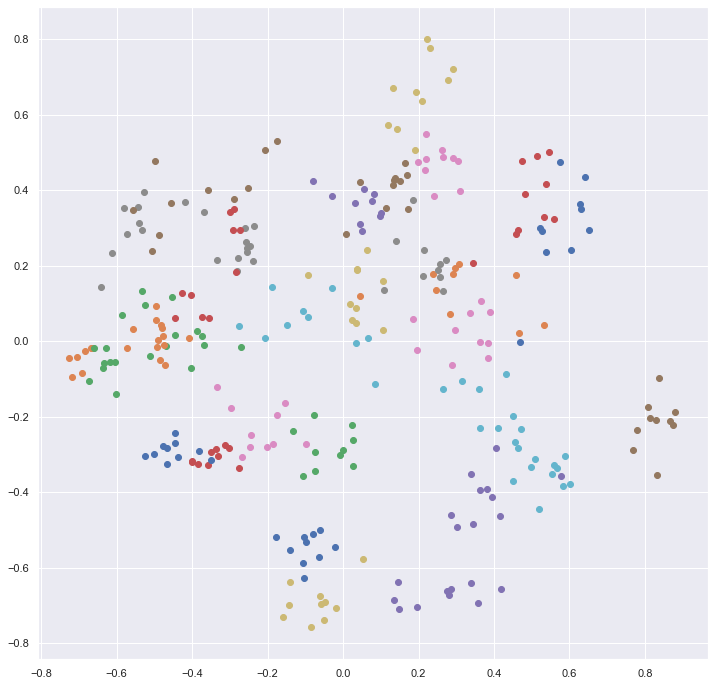

common_voice 140
Loss 360.91
Similarity  max 1.00 min -0.59
Clusterness (+) avg 0.51 var 0.22
Distance    (-) avg 0.01 var 0.05
Variance 0.31


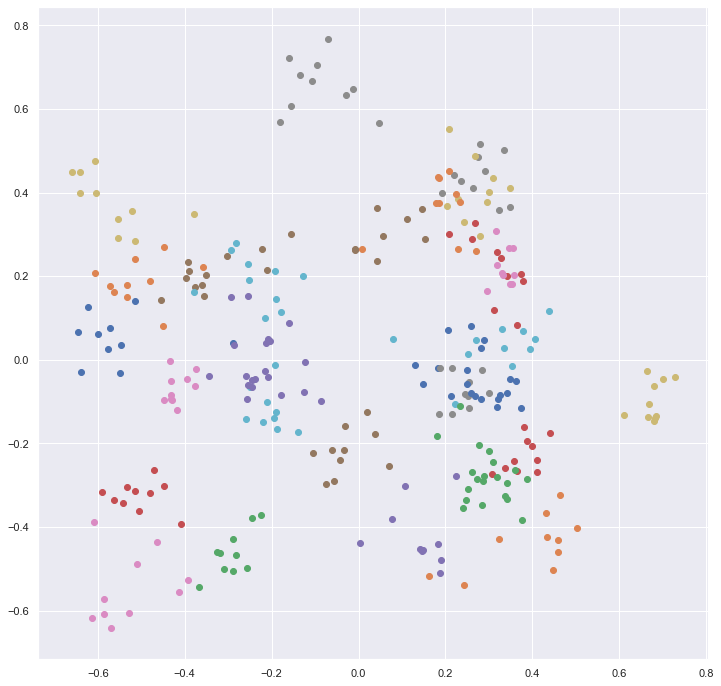

common_voice 196
Loss 396.12
Similarity  max 1.00 min -0.61
Clusterness (+) avg 0.51 var 0.23
Distance    (-) avg 0.03 var 0.04
Variance 0.31


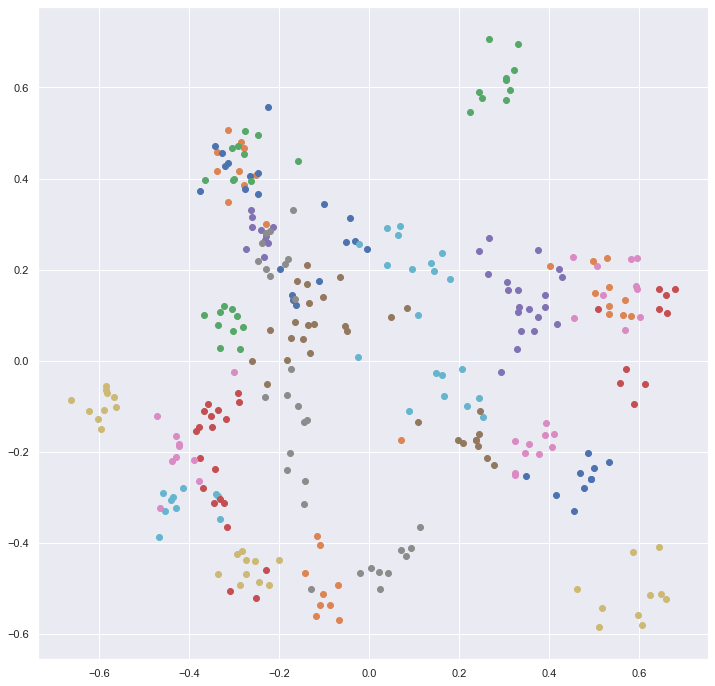

common_voice + konekorpus 80
Loss 600.45
Similarity  max 1.00 min -0.77
Clusterness (+) avg 0.49 var 0.25
Distance    (-) avg 0.06 var 0.09
Variance 0.46


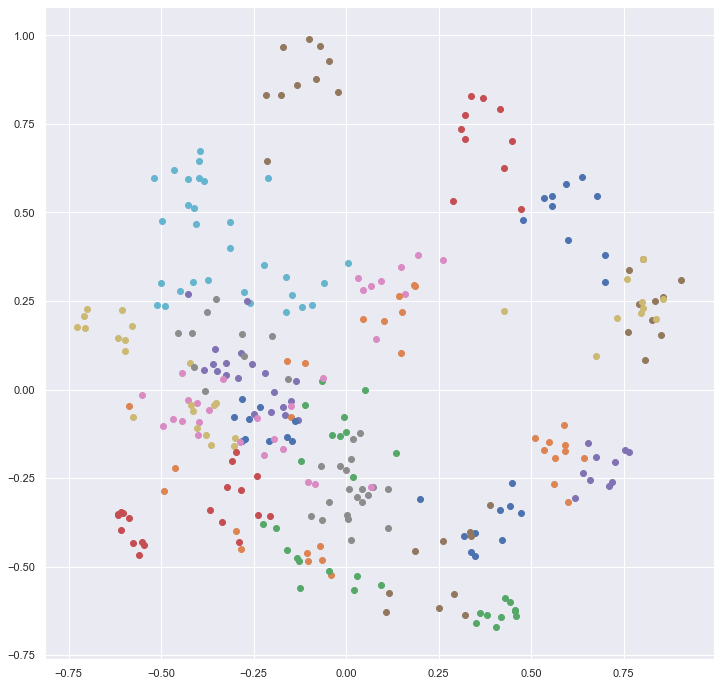

common_voice + konekorpus 140
Loss 368.66
Similarity  max 1.00 min -0.67
Clusterness (+) avg 0.51 var 0.22
Distance    (-) avg 0.03 var 0.05
Variance 0.36


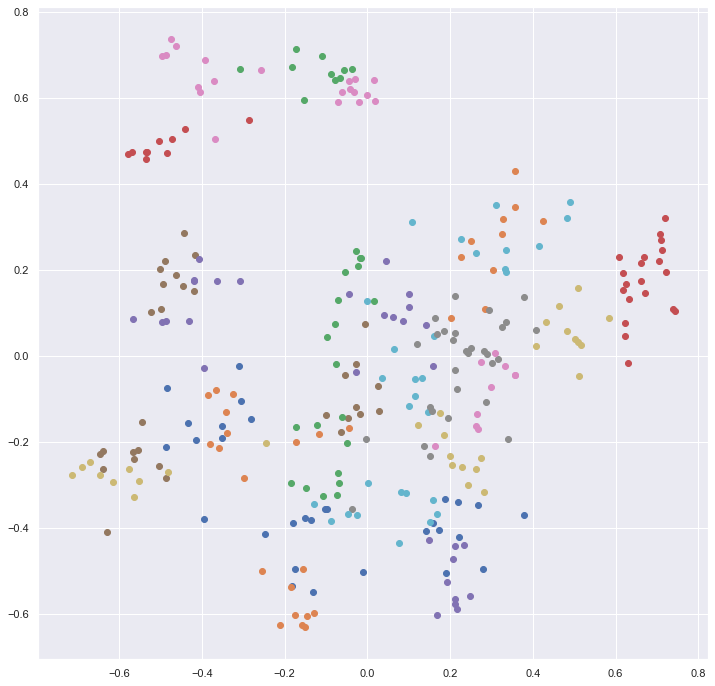

common_voice + konekorpus 180
Loss 368.51
Similarity  max 1.00 min -0.61
Clusterness (+) avg 0.50 var 0.23
Distance    (-) avg 0.02 var 0.05
Variance 0.33


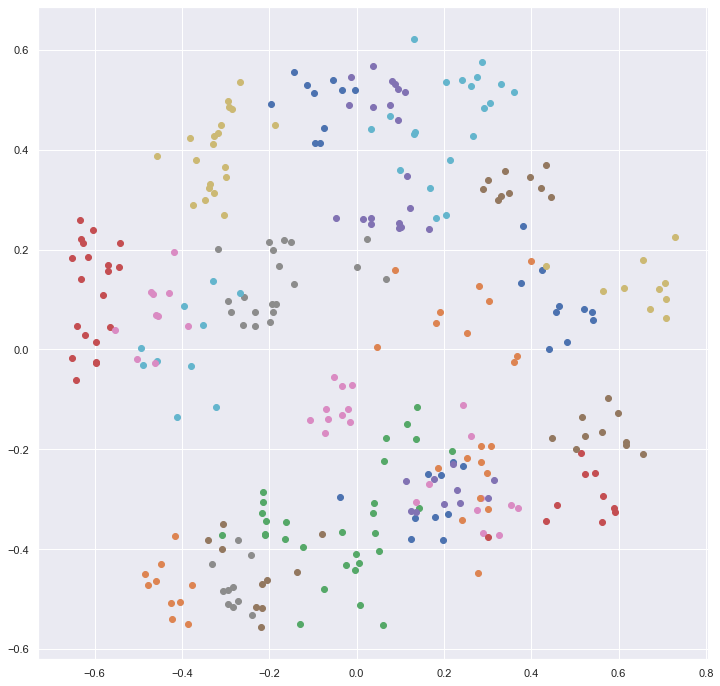

vctk 80
Loss 625.24
Similarity  max 1.00 min -0.39
Clusterness (+) avg 0.75 var 0.06
Distance    (-) avg 0.56 var 0.05
Variance 0.55


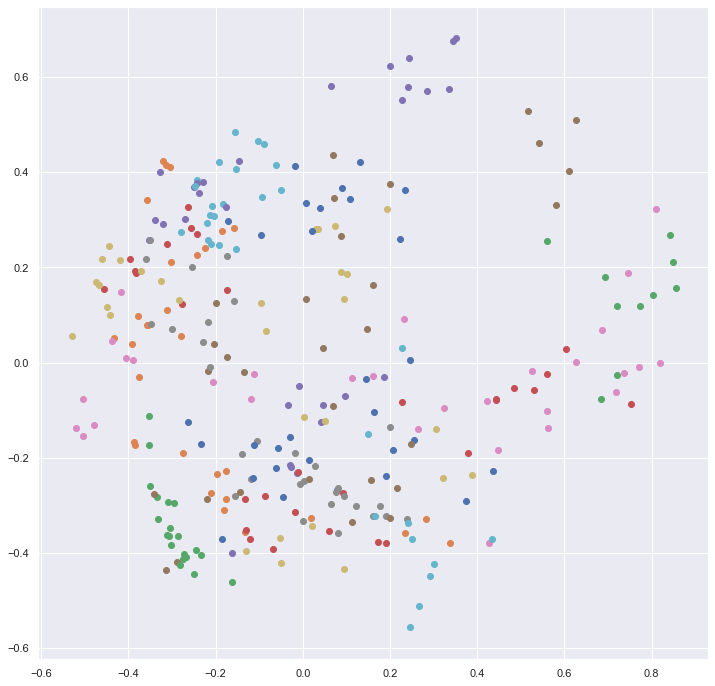

vctk 140
Loss 661.36
Similarity  max 1.00 min -0.44
Clusterness (+) avg 0.68 var 0.08
Distance    (-) avg 0.48 var 0.05
Variance 0.54


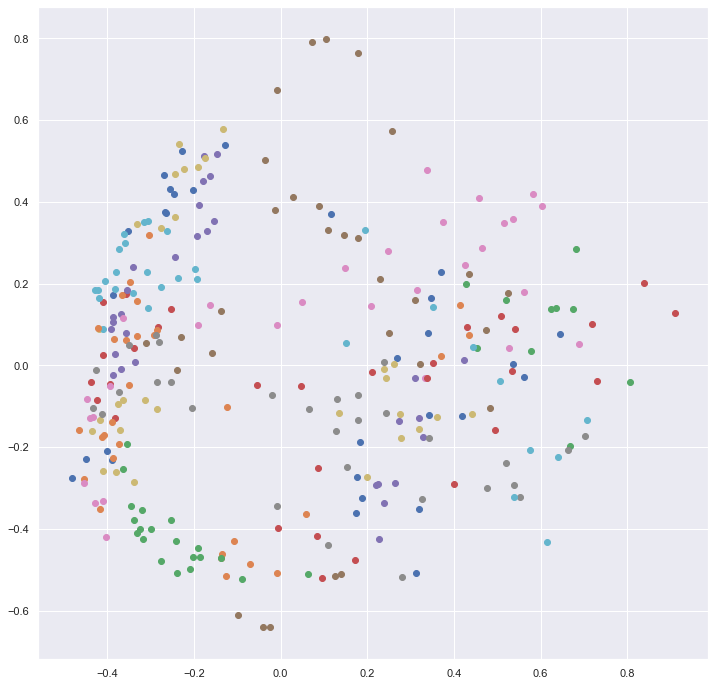

vctk 216
Loss 675.16
Similarity  max 1.00 min -0.29
Clusterness (+) avg 0.68 var 0.07
Distance    (-) avg 0.49 var 0.05
Variance 0.50


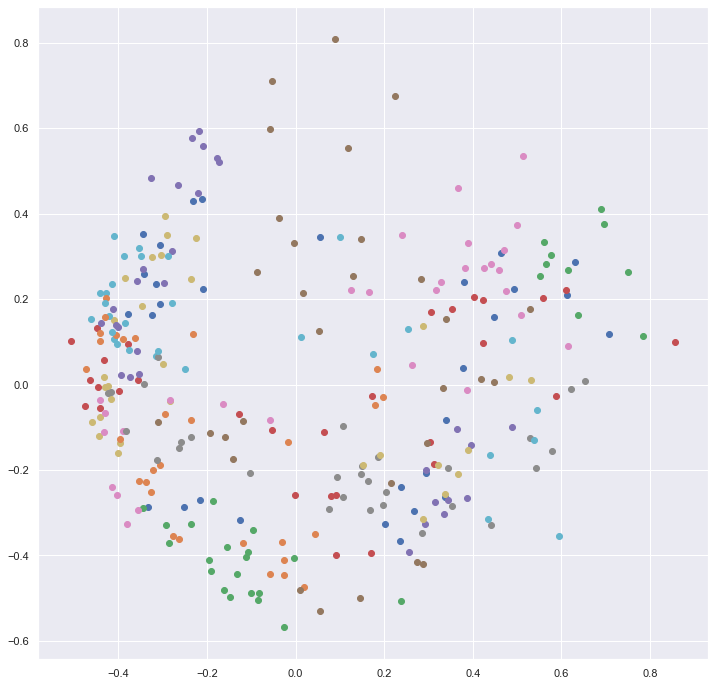

In [28]:
common_voice_stats = {}
for name, checkpoint in models.items():
    model = load_model(checkpoint)
    print(name)
    common_voice_stats[name] = run_test_common_voice(model)

In [43]:
print('\n'.join('\t'.join(map(lambda f: f'{f:.2f}', stats)) for stats in konekorpus_stats.values()))

2.48	1.00	-0.97	1.00	0.00	-0.09	0.11	0.66
53.40	1.00	-0.42	0.87	0.01	0.34	0.09	0.69
31.43	1.00	-0.50	0.77	0.03	0.19	0.07	0.56
34.02	1.00	-0.55	0.79	0.02	0.24	0.06	0.55
9.40	1.00	-0.44	0.97	0.00	0.23	0.05	0.64
5.97	1.00	-0.32	0.97	0.00	0.16	0.03	0.52
5.86	1.00	-0.25	0.96	0.00	0.18	0.02	0.48
74.40	1.00	-0.39	0.84	0.03	0.30	0.11	0.68
49.15	1.00	-0.43	0.85	0.02	0.23	0.10	0.66
39.77	1.00	-0.47	0.79	0.02	0.21	0.08	0.60
